## Standard Map

In [1]:
import os
import sys
import pathlib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
sys.path.append("..")
from prepare_data import PrepareData, StandardMap, StandardMapTraj  # noqa E402
from GFNN import GFNN  # noqa E402

/Users/sankaran/opt/miniconda3/envs/deep/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare Data

In [2]:
CURRENT_DIR = str(pathlib.Path(".").parent.absolute())
K = 1.2
prefix = "chaotic_"
train_file_path, test_file_path = PrepareData(CURRENT_DIR + "/data",
                                              K=K,
                                              p0=0, t0=0.1,
                                              n_train=1000000,
                                              n_test=100,
                                              seq_len=5,
                                              n_processors=1,
                                              prefix=prefix)

parameters = {
    "dim": 1,
    "step_size": 1,
    "train_file_path": train_file_path,
    "test_file_path": test_file_path,
    "batch_size": 1000,
    "n_neurons": [2, 500, 500, 200, 20, 1],
    "lr": 1e-3,
}

STORAGE_DIR = CURRENT_DIR + "/" + prefix + "K=" + str(K) + "/"
if not os.path.exists(STORAGE_DIR):
    os.mkdir(STORAGE_DIR)

Training data already exists!
Testing data already exists!


### Initialize (load) the model

In [3]:
nn = GFNN(parameters)
# If saved checkpoint of GFNN exists, load GFNN from the checkpoint.
# Uncomment the following two lines if a loaded GFNN is deseired.
# if os.path.exists(STORAGE_DIR + "/checkpoint.pt"):
#     nn.Load(STORAGE_DIR)

### Train

In [4]:
# Train.
epochs = 20
nn.Train(epochs)

# Serialize the trained model.
nn.Save(STORAGE_DIR)

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size([1000, 2])
torch.Size([1000, 2]) torch.Size

Text(0, 0.5, 'Training loss')

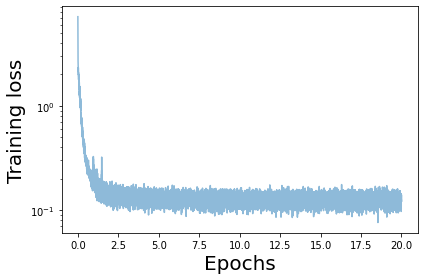

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
ax.semilogy((np.arange(len(nn.loss_array))+1)/(nn.n_train/nn.args["batch_size"]), nn.loss_array, alpha=0.5)
ax.set_xlabel("Epochs", fontsize=20)
ax.set_ylabel("Training loss", fontsize=20)

### Predict

In [ ]:
def EvolveFlow(nn, p, t, n):
    """
    Evolve the flow by the trained GFNN.
    Args:
        nn: the neural network
        q, t: the initial condition
        n: the steps to evolve
    """
    pspan = [p]
    tspan = [t]
    for i in tqdm(range(n)):
        p, t = nn.Predict(p, t)
        p = np.fmod(p+2*np.pi, 2*np.pi)
        t = np.fmod(t+2*np.pi, 2*np.pi)
        pspan.append(p)
        tspan.append(t)
    return np.array(pspan), np.array(tspan)


def EvolveExactMap(p, t, n, K):
    """
    Evolve the exact maps.
    Args:
        q, t: the initial condition.
        n: the steps to evolve.
        K: parameters in standard map.
    """
    pspan = [p]
    tspan = [t]
    for i in tqdm(range(n)):
        p, t = StandardMap(p, t, K)
        p = np.fmod(p+2*np.pi, 2*np.pi)
        t = np.fmod(t+2*np.pi, 2*np.pi)
        pspan.append(p)
        tspan.append(t)
    return np.array(pspan), np.array(tspan)



#### Evolve the flow

In [ ]:
# Initial condition for prediction
steps = 20000

p, t = np.array([0]), np.array([0.1])
pspan_exact, tspan_exact = EvolveExactMap(p, t, steps, K)
pspan_nn, tspan_nn = EvolveFlow(nn, p, t, steps)


  0%|          | 0/20000 [00:00<?, ?it/s]/Users/sankaran/Library/CloudStorage/OneDrive-UniversityofMassachusetts/Code/gfnn/standard_map/../GFNN.py:197: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  qP = torch.tensor([q, P], dtype=torch.float,
100%|██████████| 20000/20000 [03:11<00:00, 104.55it/s]


#### Plot

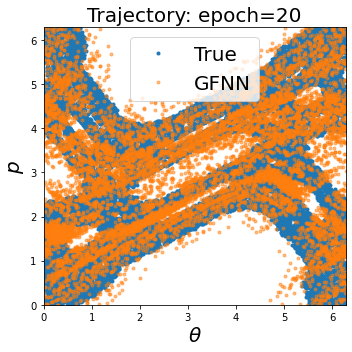

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(5, 5))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(tspan_exact, pspan_exact, '.', label='True')
ax.plot(tspan_nn, pspan_nn, '.', label='GFNN', alpha=0.5)
ax.set_xlabel(r"$\theta$", fontsize=20)
ax.set_ylabel(r"$p$", fontsize=20)
ax.set_xlim([0,2*np.pi])
ax.set_ylim([0,2*np.pi])
ax.set_title("Trajectory: epoch=" + str(nn.epoch), fontsize=20)
ax.legend(fontsize=20)